In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [3]:
print(sklearn.__version__)

0.24.1


In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [5]:
data = pd.read_csv('stoch_corr_tanh_rho_1000.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1003:1004]

In [7]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [8]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 999)


In [9]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.relu))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             65024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 71,377
Trainable params: 71,377
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.mse,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.2, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/25
1250/1250 [==============================] - 23s 13ms/step - loss: 1.0871e-04 - val_loss: 7.4270e-05
Epoch 2/25
1250/1250 [==============================] - 17s 13ms/step - loss: 7.5801e-05 - val_loss: 7.4176e-05
Epoch 3/25
1250/1250 [==============================] - 16s 13ms/step - loss: 7.5447e-05 - val_loss: 7.4159e-05
Epoch 4/25
1250/1250 [==============================] - 17s 14ms/step - loss: 7.5021e-05 - val_loss: 7.3987e-05
Epoch 5/25
1250/1250 [==============================] - 17s 14ms/step - loss: 7.3068e-05 - val_loss: 7.6249e-05
Epoch 6/25
1250/1250 [==============================] - 17s 14ms/step - loss: 7.1425e-05 - val_loss: 7.5069e-05


In [11]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.005:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0]) 
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    # print(test_output, params_reshape[i])

100%|██████████| 500/500 [00:22<00:00, 22.18it/s]


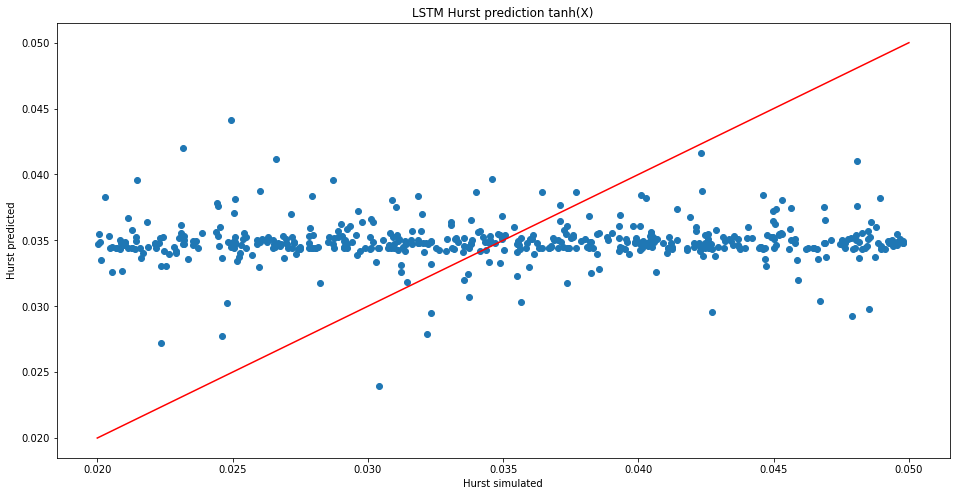

In [12]:
plt.figure(figsize=(16,8))
plt.plot([0.02,0.05], [0.02,0.05], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('Hurst simulated')
plt.ylabel('Hurst predicted')
plt.title('LSTM Hurst prediction tanh(X)')
plt.show()

In [13]:
simulated = []
predicted = []

append_index = 0
start = 10000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.005:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0]) 
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    print(test_output, params_reshape[i])

  1%|          | 3/500 [00:00<00:21, 22.90it/s][[0.03450464]] [[0.04660336]]
[[0.03429247]] [[0.03935885]]
[[0.03440297]] [[0.03605855]]
[[0.03489669]] [[0.02427829]]
[[0.03471883]] [[0.04409096]]
  2%|▏         | 9/500 [00:00<00:21, 22.77it/s][[0.03452983]] [[0.04135684]]
[[0.03442693]] [[0.04552953]]
[[0.03440806]] [[0.02401728]]
[[0.03465606]] [[0.02408172]]
  2%|▏         | 12/500 [00:00<00:21, 22.60it/s] [[0.0400683]]
[[0.03454644]] [[0.0373418]]
[[0.03416511]] [[0.02781732]]
[[0.03433653]] [[0.026613]]
  3%|▎         | 17/500 [00:00<00:21, 22.28it/s] [[0.04517577]]
[[0.03437214]] [[0.02189293]]
[[0.03428321]] [[0.02569311]]
[[0.03232093]] [[0.04732942]]
[[0.0355614]] [[0.04027542]]
  5%|▍         | 23/500 [00:01<00:20, 23.27it/s][[0.03105323]] [[0.02791539]]
[[0.03231209]] [[0.02533925]]
[[0.03490489]] [[0.04848235]]
[[0.03444331]] [[0.04421588]]
[[0.03423207]] [[0.04412877]]
[[0.03522647]] [[0.0380035]]
  6%|▌         | 29/500 [00:01<00:19, 23.68it/s][[0.03478388]] [[0.02558298]

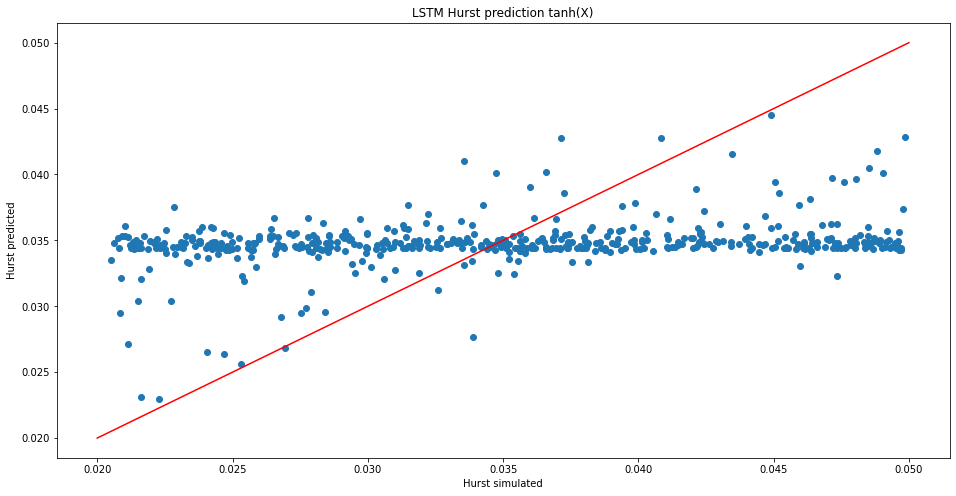

In [14]:
plt.figure(figsize=(16,8))
plt.plot([0.02,0.05], [0.02,0.05], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('Hurst simulated')
plt.ylabel('Hurst predicted')
plt.title('LSTM Hurst prediction tanh(X)')
plt.show()

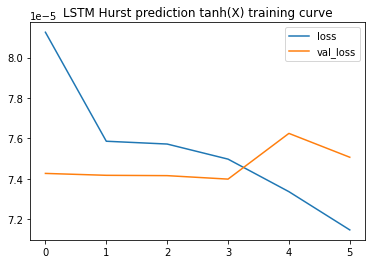

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Hurst prediction tanh(X) training curve')
plt.legend(['loss', 'val_loss'])
plt.show()